In [190]:
import pandas as pd
import statsmodels.formula.api as smf
pd.set_option('display.float_format', '{:,.2f}'.format)
from matplotlib import pyplot as plt


In [191]:
#references
#https://matheusfacure.github.io/ , 
#https://ds4ps.org/pe4ps-textbook/docs/p-030-diff-in-diff.html?fbclid=IwZXh0bgNhZW0CMTEAAR34tdrusWO00_NqgbWoWHbParx6kevu4nh3eEnmtfsRF-KfbAUYLaVLxsM_aem_49IJCEbvV4TgNr6kxWgHGw

In [192]:
print('''
Problem Statement
The U.S. Department of Housing and Urban Development (HUD) has implemented a policy to subsidize housing in low-income areas. While the policy aims to provide affordable housing, critics argue that it might negatively impact nearby property values, potentially lowering house prices in adjacent areas.

How Can We Measure the Effect of This Program?
To assess the impact of this policy, we face a common challenge in policy evaluation: isolating the causal effect of the intervention from other factors that naturally influence outcomes over time.

The Broader Challenge of Measuring Policy Effects
This question is part of a larger set of problems around evaluating the effects of policies, programs, or interventions. Examples include:

Does providing free lunches in schools improve student test scores?
Do lockdowns during the COVID-19 pandemic reduce air pollution levels?
Do billboard advertisements drive an increase in customer conversions?
In such cases, we cannot rely on simple "before and after" comparisons. Changes over time might occur naturally, independent of the policy or intervention. For instance, broader economic trends, seasonal variations, or other external factors could lead to differences that would have been present regardless of the policy. Ignoring these factors could lead to misleading conclusions.

The Difference-in-Differences (DiD) Methodology
To address this challenge, we can use the Difference-in-Differences (DiD) methodology. DiD helps account for differences across groups and over time, allowing us to isolate the effect of the policy. The key idea is to compare changes over time in an affected group (treatment group) with changes in an unaffected group (control group).

Key Components of DiD
-Treatment group: Areas directly impacted by the policy.
-Control group: Areas not affected by the policy but similar in other characteristics.
-Time periods: Comparison of outcomes "before" and "after" the policy implementation for both groups.
-Parallel trends assumption: The control group serves as a counterfactual, assuming it would have followed the same trends as the treatment group in the absence of the policy.

This notebook uses a simplified example of housing prices to demonstrate the DiD approach. By carefully defining the treatment and control groups and analyzing the changes in housing prices over time, we aim to measure the policy's true effect while accounting for external factors. This framework can be adapted to evaluate other policy impacts effectively.
''')



Problem Statement
The U.S. Department of Housing and Urban Development (HUD) has implemented a policy to subsidize housing in low-income areas. While the policy aims to provide affordable housing, critics argue that it might negatively impact nearby property values, potentially lowering house prices in adjacent areas.

How Can We Measure the Effect of This Program?
To assess the impact of this policy, we face a common challenge in policy evaluation: isolating the causal effect of the intervention from other factors that naturally influence outcomes over time.

The Broader Challenge of Measuring Policy Effects
This question is part of a larger set of problems around evaluating the effects of policies, programs, or interventions. Examples include:

Does providing free lunches in schools improve student test scores?
Do lockdowns during the COVID-19 pandemic reduce air pollution levels?
Do billboard advertisements drive an increase in customer conversions?
In such cases, we cannot rely on

In [193]:
df = pd.read_csv('https://raw.githubusercontent.com/DS4PS/pe4ps-textbook/master/data/diff-in-diff-housing-example.csv')
print('''
Key Variables:
House_Price: Price of the House ($)
Group: 0 or 1 to indicate if in the control or treamtment (D)
Post_Treatment: 0 or 1 to indicate before or after
''')


Key Variables:
House_Price: Price of the House ($)
Group: 0 or 1 to indicate if in the control or treamtment (D)
Post_Treatment: 0 or 1 to indicate before or after



In [194]:
df.head()

,House_Price,Group,Post_Treatment
0,"213,680.00",0,0
1,"229,355.00",0,1
2,"190,580.00",1,0
3,"188,669.00",1,1
4,"253,574.00",0,0


In [195]:
print('''
With the data cleaned, We need to identify 4 components
Control: Before & After
Treatment: Before & After
''')


With the data cleaned, We need to identify 4 components
Control: Before & After
Treatment: Before & After



In [196]:
df.columns = ['Price' ,'Group', 'Period']

#Aggregate to get Difference of Differences
agg_df = df.groupby(['Group', 'Period']).mean().reset_index()
agg_df.Group.replace(0, 'Control', inplace=True)
agg_df.Group.replace(1, 'Treatment', inplace=True)
agg_df.Period.replace(0, 'Before', inplace=True)
agg_df.Period.replace(1, 'After', inplace=True)
agg_df

,Group,Period,Price
0,Control,Before,"216,672.55"
1,Control,After,"251,903.43"
2,Treatment,Before,"233,133.76"
3,Treatment,After,"302,430.69"


In [197]:
control_before = agg_df.query('Group == "Control" and Period == "Before"')['Price'].values[0]
control_after = agg_df.query('Group == "Control" and Period == "After"')['Price'].values[0]
treatment_before = agg_df.query('Group == "Treatment" and Period == "Before"')['Price'].values[0]
treatment_after = agg_df.query('Group == "Treatment" and Period == "After"')['Price'].values[0]

(control_before, control_after, treatment_before, treatment_after)

(216672.548, 251903.428, 233133.756, 302430.688)

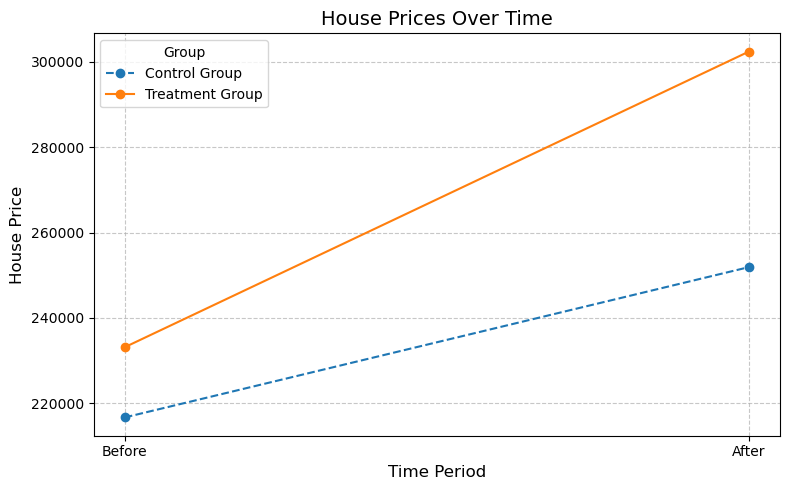

In [198]:
# Plotting
plt.figure(figsize=(8, 5))
categories = ['Before', 'After']

plt.plot(categories, [control_before, control_after], marker='o', label='Control Group', linestyle='--')
plt.plot(categories, [treatment_before, treatment_after], marker='o', label='Treatment Group', linestyle='-')

# Adding labels and title
plt.title('House Prices Over Time', fontsize=14)
plt.xlabel('Time Period', fontsize=12)
plt.ylabel('House Price', fontsize=12)
plt.legend(title='Group', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)

# Show plot
plt.tight_layout()
plt.show()

In [82]:
diff_control = (control_after-control_before)
diff_treatment = (treatment_after-treatment_before)

print(f"Differences in the Control group over time is: {diff_control:,.2f}")
print(f"Differences in the Treatment group over time is: {diff_treatment:,.2f}")

Differences in the Control group over time is: 35,230.88
Differences in the Treatment group over time is: 69,296.93


In [84]:
did = diff_treatment - diff_control
print(f"Differences of Differences: {diff_control:,.2f}")


Differences of Differences: 35,230.88


In [107]:
#We have manually calculated these, but let's see how we can do this in a regression


This visually represents all the Beta's that come into play

| Group        | Pre-Treatment ($\text{Post} = 0$)    | Post-Treatment ($\text{Post} = 1$)     | Difference Over Time        |
|--------------|--------------------------------------|----------------------------------------|-----------------------------|
| **Control**  | $\beta_0$                           | $\beta_0 + \beta_2$                   | $\beta_2$                  |
| **Treatment**| $\beta_0 + \beta_1$                 | $\beta_0 + \beta_1 + \beta_2 + \beta_3$ | $\beta_2 + \beta_3$       |

Y: Outcome Variable
Treatment: Binary , Control or Treatment Group
Post: Binary, Before or Fater

In [201]:
model = smf.ols('Price~Period+Group+Period*Group', data=df).fit().summary().tables[1]
model

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,2.167e+05,3741.999,57.903,0.000,2.09e+05,2.24e+05
Period,3.523e+04,5291.986,6.657,0.000,2.48e+04,4.56e+04
Group,1.646e+04,5291.986,3.111,0.002,6076.486,2.68e+04
Period:Group,3.407e+04,7483.998,4.552,0.000,1.94e+04,4.88e+04


In [113]:
print('''
Results:
What does this tell us? Well Each beta has it's own test . Let's walk through each Case


B0: This is referring to our Control Group at t=0. This is significant and not 0, average price $216k

B1: Referenceing our treatment Group, T=0, so the groups had a different average price. Since the test group average price is B0+B1, thus 216k+16k=233k

B2: References our Period variable, also significant and not 0. 35k refers to the delta in the control group, 
ergo our final average price for the control group is 216k + 35k=251k

B3: The meat of the problem! This refers to the difference in differences, acconting for time and group. 34k refers to price increase due to the policy , compared to the counterfacutal (To be discussed later)
''')


Results:
What does this tell us? Well Each beta has it's own test . Let's walk through each Case


B0: This is referring to our Control Group at t=0. This is significant and not 0, average price $216k

B1: Referenceing our treatment Group, T=0, so the groups had a different average price. Since the test group average price is B0+B1, thus 216k+16k=233k

B2: References our Period variable, also significant and not 0. 35k refers to the delta in the control group, 
ergo our final average price for the control group is 216k + 35k=251k

B3: The meat of the problem! This refers to the difference in differences, acconting for time and group. 34k refers to price increase due to the policy , compared to the counterfacutal (To be discussed later)



In [115]:
print('''

So what? Well suppose this policy didn't exist in another universe? What would our "treatment" group final price be. 

Well thanks to our beta's above we can estimate that. by doing B0+B1+B2, as we turn off "B3".
''')



So what? Well suppose this policy didn't exist in another universe? What would our "treatment" group final price be. 

Well thanks to our beta's above we can estimate that. by doing B0+B1+B2, as we turn off "B3".



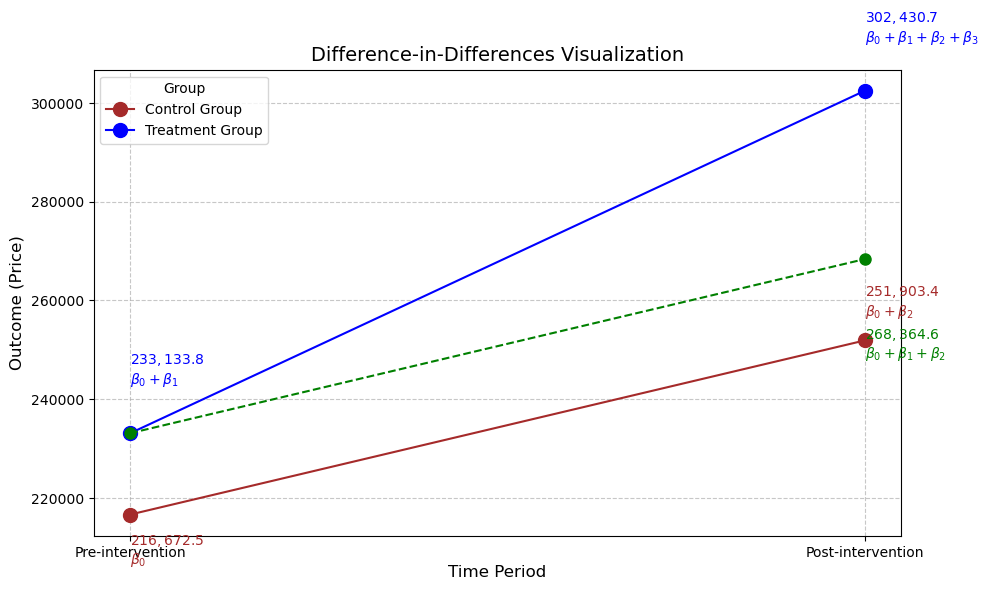

In [126]:
# Extract coefficients
coeff = smf.ols('Price ~ Period * Group', data=df).fit().params
beta_0 = coeff['Intercept']
beta_1 = coeff['Group']
beta_2 = coeff['Period']
beta_3 = coeff['Period:Group']


#Calculate
pre_control = beta_0
post_control = beta_0 + beta_2

pre_treatment = beta_0 + beta_1
post_treatment = beta_0 + beta_1 + beta_2 + beta_3

plt.figure(figsize=(10, 6))

# Control group
plt.plot(["Pre-intervention", "Post-intervention"], [pre_control, post_control], 
         color="brown", marker="o", label="Control Group", linestyle="-", markersize=10)
plt.text(0, pre_control - 10000, f"${pre_control:,.1f}$\n$\\beta_0$", color="brown", fontsize=10)
plt.text(1, post_control + 5000, f"${post_control:,.1f}$\n$\\beta_0 + \\beta_2$", color="brown", fontsize=10)

# Treatment group
plt.plot(["Pre-intervention", "Post-intervention"], [pre_treatment, post_treatment], 
         color="blue", marker="o", label="Treatment Group", linestyle="-", markersize=10)
plt.text(0, pre_treatment + 10000, f"${pre_treatment:,.1f}$\n$\\beta_0 + \\beta_1$", color="blue", fontsize=10)
plt.text(1, post_treatment + 10000, f"${post_treatment:,.1f}$\n$\\beta_0 + \\beta_1 + \\beta_2 + \\beta_3$", color="blue", fontsize=10)

# Expected counterfactual for treatment group (dashed green line)
plt.plot(["Pre-intervention", "Post-intervention"], [pre_treatment, pre_treatment + beta_2], 
         color="green", marker="o", linestyle="--", markersize=8)
plt.text(1, pre_treatment + beta_2 - 20000, 
         f"${pre_treatment + beta_2:,.1f}$\n$\\beta_0 + \\beta_1 + \\beta_2$", color="green", fontsize=10)

plt.title("Difference-in-Differences Visualization", fontsize=14)
plt.xlabel("Time Period", fontsize=12)
plt.ylabel("Outcome (Price)", fontsize=12)
plt.legend(title="Group", fontsize=10)
plt.grid(linestyle="--", alpha=0.7)
plt.tight_layout()

# Show the plot
plt.show()

In [137]:
#Did Elimination of copayment increase visits to the phyisicans
#In 2010 they eliminated the program fr 16 and below

df = pd.read_csv('https://raw.githubusercontent.com/hmelberg/causal/refs/heads/master/data/visits.csv')
df.head()

,Unnamed: 0,year,age,sex,consultations,population,perCapita
0,4,2006,1,f,"67,194.00","28,221.00",2.38
1,7,2006,2,f,"49,802.00","28,361.00",1.76
2,10,2006,3,f,"42,741.00","27,899.00",1.53
3,13,2006,4,f,"36,555.00","28,420.00",1.29
4,16,2006,5,f,"33,319.00","29,479.00",1.13


In [138]:
df['visits'] = df['consultations']

In [139]:
df

,Unnamed: 0,year,age,sex,consultations,population,perCapita,visits
0,4,2006,1,f,"67,194.00","28,221.00",2.38,"67,194.00"
1,7,2006,2,f,"49,802.00","28,361.00",1.76,"49,802.00"
2,10,2006,3,f,"42,741.00","27,899.00",1.53,"42,741.00"
3,13,2006,4,f,"36,555.00","28,420.00",1.29,"36,555.00"
4,16,2006,5,f,"33,319.00","29,479.00",1.13,"33,319.00"
...,...,...,...,...,...,...,...,...
707,2543,2013,85,f,"50,876.00","10,696.00",4.76,"50,876.00"
708,2546,2013,86,f,"46,102.00","10,393.00",4.44,"46,102.00"
709,2548,2013,87,f,"41,468.00","9,243.00",4.49,"41,468.00"
710,2550,2013,88,f,"35,440.00","8,763.00",4.04,"35,440.00"


<Axes: xlabel='age'>

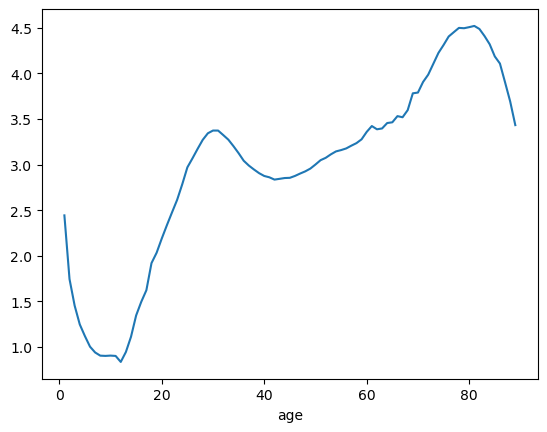

In [141]:
df.groupby('age')['perCapita'].mean().plot()

In [142]:
df14 = df.query('age==14')

<Axes: xlabel='year'>

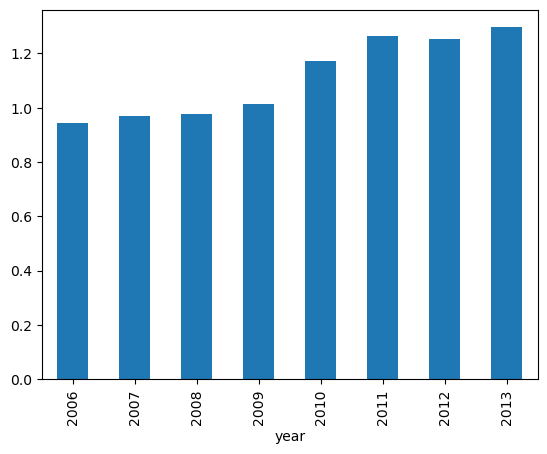

In [144]:
df14.set_index('year').perCapita.plot.bar()

In [171]:
df2 = df.query('age==14 or age==25')
df2= df2[['year','age','perCapita']]

<Axes: xlabel='year'>

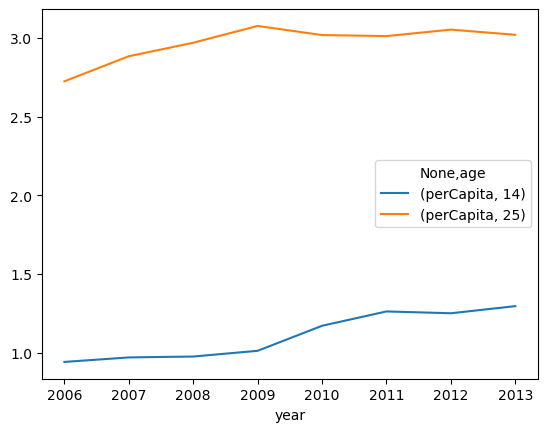

In [172]:
df2.set_index(['year','age']).unstack('age').plot()

In [153]:
df14and45 = df2.set_index(['year', 'age']).unstack('age')
df14and45

perCapita     
age         14   25
year               
2006      0.94 2.72
2007      0.97 2.88
2008      0.98 2.97
2009      1.01 3.08
2010      1.17 3.02
2011      1.26 3.01
2012      1.25 3.05
2013      1.30 3.02

In [155]:
df14and45['copay'] = 0
df14and45['copay'] = df14and45.copay.where(df14and45.index<2010, 1)
df14and45

perCapita      copay
age         14   25      
year                     
2006      0.94 2.72     0
2007      0.97 2.88     0
2008      0.98 2.97     0
2009      1.01 3.08     0
2010      1.17 3.02     1
2011      1.26 3.01     1
2012      1.25 3.05     1
2013      1.30 3.02     1

In [158]:
result = df14and45.groupby('copay').mean()
result.columns = ['age_14', 'age_45']
result

,age_14,age_45
copay,,
0,0.98,2.91
1,1.25,3.03


In [159]:
result['age_45'] - result['age_14']


copay
0   1.94
1   1.78
dtype: float64

In [160]:
(result['age_45'] - result['age_14']).diff()


copay
0     NaN
1   -0.16
dtype: float64

In [161]:
df2


,year,age,perCapita
13,2006,14,0.94
24,2006,25,2.72
102,2007,14,0.97
113,2007,25,2.88
191,2008,14,0.98
202,2008,25,2.97
280,2009,14,1.01
291,2009,25,3.08
369,2010,14,1.17
380,2010,25,3.02


In [184]:
df2['copay']=0
df2['copay']=df2['copay'].where(df2.year<2010,1)
df2['age_14'] = 0
df2['age_14']=df2['age_14'].mask(df2.age==14,1)

df2

,year,age,perCapita,copay,age_14
13,2006,14,0.94,0,1
24,2006,25,2.72,0,0
102,2007,14,0.97,0,1
113,2007,25,2.88,0,0
191,2008,14,0.98,0,1
202,2008,25,2.97,0,0
280,2009,14,1.01,0,1
291,2009,25,3.08,0,0
369,2010,14,1.17,1,1
380,2010,25,3.02,1,0


In [185]:
import statsmodels.formula.api as smf


In [186]:
model = 'perCapita ~ copay + C(age) + C(age)*copay'
mod = smf.ols(formula=model, data=df2)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:              perCapita   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.993
Method:                 Least Squares   F-statistic:                     716.5
Date:                Thu, 26 Dec 2024   Prob (F-statistic):           8.57e-14
Time:                        16:08:36   Log-Likelihood:                 19.871
No. Observations:                  16   AIC:                            -31.74
Df Residuals:                      12   BIC:                            -28.65
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.9752      0

/opt/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [188]:
model = 'perCapita ~ age_14 +copay +copay*age_14+year'
mod = smf.ols(formula=model, data=df2)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:              perCapita   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                     987.2
Date:                Thu, 26 Dec 2024   Prob (F-statistic):           5.65e-14
Time:                        16:09:28   Log-Likelihood:                 25.410
No. Observations:                  16   AIC:                            -40.82
Df Residuals:                      11   BIC:                            -36.96
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      -85.7891     26.764     -3.205   

/opt/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [178]:
df2


,year,age,perCapita,copay,age_14
13,2006,14,0.94,0,0
24,2006,25,2.72,0,1
102,2007,14,0.97,0,0
113,2007,25,2.88,0,1
191,2008,14,0.98,0,0
202,2008,25,2.97,0,1
280,2009,14,1.01,0,0
291,2009,25,3.08,0,1
369,2010,14,1.17,1,0
380,2010,25,3.02,1,1
